- [深度强化学习 ( DQN ) 初探](https://www.qcloud.com/community/article/549802?fromSource=gwzcw.114127.114127.114127)
- [DQN 从入门到放弃1 DQN与增强学习](https://zhuanlan.zhihu.com/p/21262246?refer=intelligentunit)
- [DQN 从入门到放弃2 增强学习与MDP](https://zhuanlan.zhihu.com/p/21292697?refer=intelligentunit)
- [DQN 从入门到放弃3 价值函数与Bellman方程](https://zhuanlan.zhihu.com/p/21340755?refer=intelligentunit)
- [DQN 从入门到放弃4 动态规划与Q-Learning](https://zhuanlan.zhihu.com/p/21378532?refer=intelligentunit)
- [DQN从入门到放弃5 深度解读DQN算法](https://zhuanlan.zhihu.com/p/21421729)
- [Batch Normalization学习笔记及其实现](https://zhuanlan.zhihu.com/p/26138673)

In [1]:
%pylab inline
import gym
import math
import random
import numpy as np
import pandas as pd
from collections import namedtuple
from itertools import count
from copy import deepcopy
from PIL import Image
import seaborn as sns
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})

Populating the interactive namespace from numpy and matplotlib


# 前言
本案例通过采用DQN模型来训练一个AI玩CartPole-v0的游戏。
### 强化学习算法
强化学习强调如何基于环境而行动，以取得最大化的预期利益，即有机体如何在环境给予的奖励或惩罚的刺激下，逐步形成对刺激的预期，产生能获得最大利益的习惯性行为。

在强化学习的世界里，算法称之为Agent，与环境发生交互，Agent从环境中获取状态state，并决定自己要做出的动作action，环境会根据自身的逻辑给Agent予以奖励（reward）。有正向和反向的激励。

### 马尔科夫决策过程
环境是随机的，AI可以在环境中做出某些特定的动作，行为可以改变环境，并带来新的状态，代理可以再执行下一个动作。我们在选择这些动作的规则就叫做策略。

状态与动作的集合加上改变状态的规则，就组成了一个马尔科夫决策过程。这个过程的一个情节（episode）形成了状态、动作与奖励的有限序列。
> $$s_0, a_0, r_1, s_1, a_1, r_2, s_2, ... ,s_{n-1}, a_{n-1}, r_n, s_n$$


### 策略policy
状态State和动作Action存在映射关系，也就是一个state对应一个action，或者对应不同的概率（概率最高的就是最值得执行的动作）。状态与动作的关系其实就是输入与输出关系，而状态State到动作Action的过程就称之为一个策略Policy，一般用$\pi$来表示，需要找到以下关系：
$$a=\pi(s)或\pi(a|s)$$
> 增强学习的任务就是找到一个最优的策略policy从而使reward最多。


### 折扣未来的奖励
我们在决定动作的时候，不仅要考虑即时的奖励，也需要考虑得到的未来的奖励。对于给定的马尔科夫决策过程的一次运行，我们可以很容易的计算一个情节的总奖励：
$$R = r_1 + r_2 + r_3 + ... + r_n$$ 
因此，时间t的未来总回报为：
$$R_t = r_t + r_{t+1} + r_{t+2} + r_{t+3}+...+r_{t+n}$$
由于环境是随机的，无法确定相同的动作得到一样的奖励，因此需要利用折扣未来奖励来代替：
$$R_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + ... + \gamma^{n-t}r_n$$
在这里$\gamma$为贴现因子，数值在0，1之间。用递归的方式表示：
$$R_t = r_t + \gamma(r_{t+1} + \gamma(r_{t+2} +...) = r_t + \gamma R_{t+1}$$
因此，如果我们不考虑未来的收益，那么$\gamma$应该为0，如果认为未来的环境是确定的，相同的动作导致相同的奖励，可以将贴现因子定义为$r=1$，如果希望是平衡的思路，那么$\gamma=0.9$。
> 在具体的投资过程中，市场的风格是经常多变的，所有我们的折扣因子不能为1，当然也不能为0，短期内假定市场风格不会剧烈的变动，那么设置一个偏向于短期的$\gamma$似乎是比较合理的。

### Value Function价值函数
我们做决策时有目的的，那就是为了最大化未来的回报Result。根据某个策略和当前状态，我们选择了某一个动作，这个动作使得未来的回报最大。
> if 某一个决策的价值最大：
- 选择这个决策

我们也可以使用策略+价值评估的方法联合给出决策，这种算法就是所谓的Actor-Critic算法。

### Bellman方程
一般我们基于以下几种情况来做评估：
- 其他人的选择：看到其他人的投资成功率，我们会降低我们投资股票的价值。
- 自己反复试验：我们通常不是只做一次选择，而是做了很多次选择，从而收获了所谓的“经验”的东西。我们根据经验来评估选择的价值。比如我们做了好几次投资楼市的选择，结果大获成功，因此我们就会认为投资楼市是不错的选择。
- 基于理性分析：我们根据我们已有的知识对当前的情况做分析，从而做出一定的判断。
- 基于感性的逻辑：比如选择投资自己到人工智能领域。

计算机如何才能评估：
- 其他人的选择：没有其他人
- 基于理性分析：没有人类的先验知识，无法分析，可以先用监督学习然后再用增强学习。
- 基于感性的逻辑：不行
- 基于反复的试验：可行

价值等于未来的期望回报
$$v(s) = E[R_{t+1} + \lambda v(S_{t+1})|S_t=s]$$
上面的公式为Bellman方程的基本形态，从公示上看，当前状态的价值和下一步的价值以及当前的反馈Reward有关。

### 动作价值函数
如果在状态转移之间考虑动作，那么采取不同的动作，会产生不同的序列，结果获得的回报也不同，这表明，动作也是存在价值的。显然，如果知道了每个动作的价值，那么就可以选择价值最大的一个动作去执行。这就是Action-Value function $Q^{\pi}(s, a)$。

那么有了上面的定义，动作价值函数就为如下表示：
$$Q^{\pi}(s,a)=E[r_{t+1} + \lambda r_{t+2} + \lambda^2 r_{t+3}+...|s,a]\
= E_{s^{'}}[r + \lambda Q^{\pi}(s^{'}, a^{'})|s, a]$$

### Optimal value function 最优价值函数
能计算动作价值函数是不够的，因为我们需要的是最优策略，现在求解最优策略等价于求解最优的value function，找到了最优的value function，自然而然策略也就找到了。（DQN是value-base, 后面还有Policy-based, model-based）
$$Q^{*}(s, a) = max_{\pi}Q^{\pi}(s,a)$$
最优的动作价值函数为所有策略下的动作价值函数最大值。通过这样的定义就可以使最优的动作价值函数唯一。
套用上一届得到的Value function，可以得到
$$Q^{*}(s, a) = E_{s^{'}}[r + \lambda max_{a^{'}}Q^{*}(s^{'}, a^{'})|s, a]$$
因为最优的Q值必然为最大值，等式右侧的Q值必然为使$a^{'}$取最大的Q值。

### 策略迭代 Policy Iteration
目的是通过迭代计算value function价值函数的方式来使得policy收敛到最优。
- policy evaluation策略评估。目的是更新value function,或者说更好的估计基于当前策略的价值。
- policy improvement策略改进。使用greedy policy产生新的样本用于第一步的策略评估。

本质上就是使用当前策略产生新的样本，然后使用新的样本更好的估计策略的价值，然后利用策略的价值更新策略，然后不断的反复。理论上可以证明最终的策略将收敛到最优。

### Q-learning算法描述
- 初始化Q(s, a)，设置Q(terminal-state,.) = 0
- 重复（对每一节episode）：
    - 初始化状态S
    - 重复 （对episode中的每一步）：
        - 使用某一个policy比如（e - greedy）根据状态S选取一个动作执行。
        - 执行结束后观察reward和新的状态$S^{'}$
        - $Q(S_t, A_t) <- Q(S_t, A_t) + \alpha(R_{t+1} + \lambda max_{a}Q(S_{t+1}, a)-Q(S_t, A_t))$
        - S<-$S^{'}$
    - 循环直到S终止

算法中$\alpha$是学习率，当$\alpha$为1时，结果为贝尔曼方程。更新次数越多Q函数越接近真实的Q值。

### Exploration and Exploiation探索与利用
Q-learning不需要优化policy，因此是off-policy的算法，另一方面，因为Q-Learning完全不考虑Model模型也就是环境的具体情况，只考虑看到的环境及reward，因此是model-free的方法。（PS：比较适合金融市场）

那么如何生成策略：
- 随机生成一个动作
- 根据当前Q值计算出一个最优的动作，这个policy $\pi$ 称之为greedy policy贪婪策略，也就是
$$\pi(S_{t+1}) = argmax_a Q(S_{t+1}, a)$$

使用随机的动作就是exploration，探索未知的动作会产生的效果，有利于更新Q值，而使用greedy policy也就是target policy则是exploitation，利用Policy，相对来说不好更新出更好的Q值，单可以得到更好的测试效果用于判断算法是否有效。将两者结合起来就是所谓的$\xi - greedy$策略，$\xi$一般是一个很小的值，作为选取随机动作的概率值。

### Q-table更新案例

In [2]:
# 初始化Q-table
q_table = pd.DataFrame(0, 
                       columns=['a1', 'a2', 'a3', 'a4'], 
                       index=['s1', 's2', 's3', 's4'])

In [3]:
alpha = 1
lambdas = 1

In [4]:
# 第一步在s1随机选择一个动作，得到的reward为1，并进入s3
random_action = np.random.choice(['a1', 'a2', 'a3', 'a4'])
reward = 1

In [5]:
# 更新Q值
q_table.loc['s1', random_action] = q_table.loc['s1', random_action] + alpha * (reward + lambdas * q_table.loc['s3'].max() - q_table.loc['s1', random_action])

In [6]:
q_table

,a1,a2,a3,a4
s1,0,1,0,0
s2,0,0,0,0
s3,0,0,0,0
s4,0,0,0,0


### Q-network
我们只需要对高纬状态进行降维，而不需要对动作也进行降维处理。
$Q(s)\approx f(s, w)$ 神经网络直接输出各个动作的Q值。

# 本案例描述
#### 任务
AI需要决定向左移动还是向右移动，来使得木棍保持稳定。

#### 依赖包
- 神经网络（torch.nn）
- 优化器（torch.optim）
- 自动求导（torch.autograd）
- 游戏包（gym）
- 可视化（torchvision）

In [7]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [8]:
# 载入神经网络相关包
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T
from torch import FloatTensor, LongTensor, ByteTensor

In [9]:
# 载入gym环境
env = gym.make('CartPole-v0').unwrapped

[2017-09-25 16:44:39,878] Making new env: CartPole-v0


In [10]:
Tensor = FloatTensor

# 保存回放

In [11]:
Transition = namedtuple('Transition', 
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    
    def push(self, *args):
        """保存一次交互
        """
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [12]:
r = ReplayMemory(10)

# 定义DQN网络
### Batch Normalization层
一般，如果模型的输入特征不相关且满足标准正态分布$N(0, 1)$时，模型的表现一般较好。在训练神经网络模型的时候，我们可以事先将特征去相关，并使得他们满足一个比较好的分布，这样，模型的第一层网络一般都会有一个比较好的输入特征，但是随着模型的层数加深，网络的非线性变换使得每一层结果变得相关了，且不再满足$N(0, 1)$分布，更糟糕的是，可能隐藏层的特征分布已经发生了偏离。为了解决这个问题，提出在层与层之间加入batch_normalization层，维护所有mini-batch数据的均值方差，最后利用样本的均值方差的无偏估计量用于测试时使用。

加入BN后，使得模型的训练收敛速度更快，模型隐藏输出特征的分布更稳定，更利于模型的学习。
### Variable
每个Variable有两个变量：requires_grad和volatile.
- requires_grad: 主要用于限制变量是否需要进行梯度下降。
- volatile: 纯输入接口，不能进行梯度下降。

### torch.cat
拼接数据
- torch.cat((x, x, x), 0)：纵向拼接
- torch.cat((x, x, x), 1)：横向拼接

### optim.step
- 在确定好梯度之后，更新神经网络参数

#### （1）Q-network

In [13]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(448, 2)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))  # 一层卷积
        x = F.relu(self.bn2(self.conv2(x)))  # 两层卷积
        x = F.relu(self.bn3(self.conv3(x)))  # 三层卷积
        return self.head(x.view(x.size(0), -1))  # 全连接层

#### （2）从环境中提取输入数据

```
torchvision.transforms: 主要用于进行图像转换。

```

In [14]:
resize = T.Compose([
    T.ToPILImage(),  # 转换成为PILImage
    T.Scale(40, interpolation=Image.CUBIC),  # 缩小或放大
    T.ToTensor()  # 转换成为tensor, (H X W X C) in range(255)=> (C X H X W) in range(1.0)
])

# 定义环境
screen_width = 600

def get_cart_location():
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)

def get_screen():
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))  # 转化成torch序列（CHW）
    screen = screen[:, 169:320]
    view_width = 320
    cart_location = get_cart_location()
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    screen = screen[:, :, slice_range]
    # 将图像转化成为tensor
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # 调整尺寸
    return resize(screen).unsqueeze(0).type(Tensor)

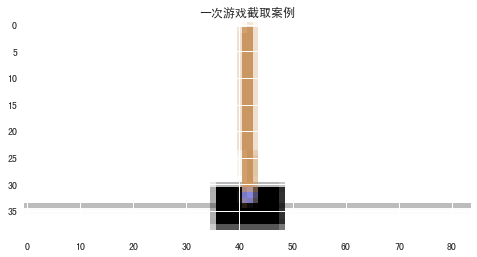

In [15]:
# 显示其中一次案例
env.reset()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(), interpolation='none')
plt.title('一次游戏截取案例');

# 训练网络
#### （1）初始化参数

In [16]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200

In [17]:
# 建立模型
model = DQN()  # 初始化对象
optimizer = optim.RMSprop(model.parameters())  # 设置优化器
memory = ReplayMemory(10000)

In [18]:
steps_done = 0

In [19]:
def select_action(state):
    """选择动作
    """
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold: # 刚开始不采用DQN进行更新，采用随机探索
        return model(Variable(state, volatile=True).type(FloatTensor)).data.max(1)[1].view(1, 1)  # 返回最优的动作
    else:
        return LongTensor([[random.randrange(2)]])

In [20]:
episode_durations = []  # 维持时间长度

In [27]:
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.FloatTensor(episode_durations)
    plt.title('训练中。。。')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # 平均没100次迭代画出一幅图
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))  # 拼接数据
        plt.plot(means.numpy())
    
    plt.pause(0.001)
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

#### (2) 设计训练函数

In [40]:
last_sync = 0

def optimize_model():
    """训练函数
    """
    global last_sync
    if len(memory) < BATCH_SIZE: # 如果样本数小于最低批次大小返回 
        return
    # 转化batch
    transitions = memory.sample(BATCH_SIZE)  # 抽样
    batch = Transition(*zip(*transitions))  # 转换成为一批次
    
    non_final_mask = ByteTensor(tuple(map(lambda s: s is not None, batch.next_state)))
    non_final_next_states = Variable(torch.cat([s for s in batch.next_state if s is not None]), volatile=True)
    state_batch = Variable(torch.cat(batch.state))
    action_batch = Variable(torch.cat(batch.action))
    reward_batch = Variable(torch.cat(batch.reward))
    
    # 计算Q(s_t, a)，选择动作
    state_action_values = model(state_batch).gather(1, action_batch)
    
    # 计算下一步的所有动作的价值V（s_{t+1}）
    next_state_values = Variable(torch.zeros(BATCH_SIZE).type(Tensor))
    next_state_values[non_final_mask] = model(non_final_next_states).max(1)[0]
    
    next_state_values.volatile = False
    # 计算预期的Q值
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    # 计算Huber loss，损失函数采用smooth_ll_loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
    
    # 优化模型
    optimizer.zero_grad()  # 清理所有参数的梯度。
    loss.backward()  # 反向传播
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)  # 将所有的梯度限制在-1到1之间
    optimizer.step()  # 更新模型的参数

#### (3) 开始训练

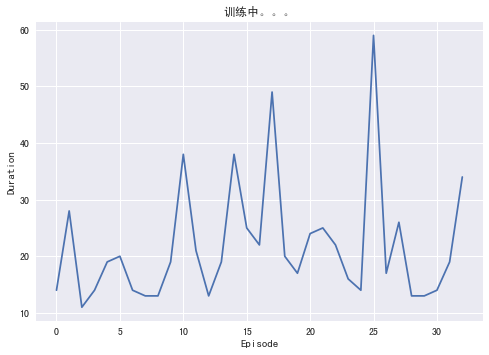

RuntimeError: the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch

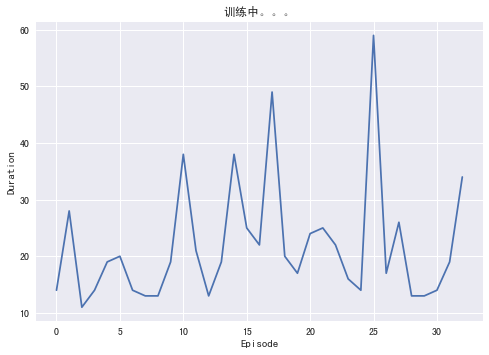

In [46]:
num_episodes = 100  # 迭代次数
for i_episode in range(num_episodes):
    # 初始化环境和状态
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen  # 定义状态，即为当前状态和最后的状态差。
    for t in count():
        # 选择并执行一个动作
        action = select_action(state)
        _, reward, done, _ = env.step(action[0, 0])  # 从环境汇中获取奖励
        reward = Tensor([reward])  # 将奖励转换成为tensor
        
        # 观察新的状态，确定下一个状态（PS：在这一步里面获取了未来信息，引用在资本市场上，未来的状态具有一定的概率分布特征。）
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None
        
        # 将转换保存起来
        memory.push(state, action, next_state, reward)
        
        # 切换到下一状态
        state = next_state
        
        # 优化模型
        optimize_model()
        # 一次游戏结束，就画图显示
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
print('完成')
env.render(close=True)
env.close()